# 중고자동차 가격 예측
---

## 데이터 소개
    - kaggle에서 제공하는 Used Car Dataset
    - 스크래핑으로 수집된 데이터
    
    - vehicles.csv
    id : 중고차 거래의 아이디
    url : 중고차 거래 페이지
    region : 해당 거래의 관리 지점
    region_url : 거래 관리 지점의 홈페이지
    price : 기입된 자동차의 거래가
    year : 중고차의 생산연도
    manufacturer : 자동차를 생산한 회사
    model : 자동차 모델명
    condition : 자동차의 상태
    cylinders : 자동차의 기통 수
    fuel : 자동차의 연료 타입
    odometer : 자동차의 운행 마일 수
    title_status : 자동차의 타이틀 상태 (소유주 등록 상태)
    transmission : 자동차의 트랜스미션 종류
    vin : 자동차의 식별 번호 (vehicle identification number)
    drive : 자동차의 구동 타입
    size : 자동차 크기
    type : 자동차의 일반 타입 (세단, ...)
    paint_color : 자동차 색상
    image_url : 자동차 이미지
    description : 세부 설명
    county : 실수로 생성된 미사용 컬럼
    state : 거래가 업로드된 미 주
    lat : 거래가 업로드된 곳의 위도
    long : 거래가 업로드된 곳의 경도
 
    
- 데이터 출처: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

## 데이터 스크래핑

- 일반적으로 웹에서 스크랩을 한다고 할 경우 html내에서 데이터의 형식을 예측해서, 해당 형식의 데이터를 가져오도록 지정 (by selenium)<br><br>
- 다만 이 경우 해당 페이지의 위치가 리뉴얼 되거나 하는 등의 변동이 있을때 위에 말한 '예측' 대로 데이터가 수집되지 않을 가능성이 높다.<br><br>
- 즉, 이상치(outlier) 데이터가 다량 발생할 가능성이 많다.<br>
    - 빈 데이터를 스크랩한 경우<br>
    - 형식이 틀린 경우 <br>
        - 문자열 : 앞뒤에 공백, html태그 포함하여 스크랩, 인코딩에 의해 깨진 문자<br>
        - 숫자 : 최대값 & 최소값으로 잘못 기입 되는 경우, 숫자 대신 문자열로 스크랩된 경우<br>

## 데이터셋 불러오기

In [1]:
# 기초 전처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

# 캔버스 사이즈 적용
plt.rcParams['figure.figsize'] = (12, 9)

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

# pandas 결과값의 표현 범위 소수점 2자리수로 변경
pd.options.display.float_format = '{:.2f}'.format

# 파일 로드위한 directory 확인 및 현재 경로로 설정
a = os.getcwd()
os.chdir(a)

In [2]:
df = pd.read_csv('vehicles.csv')

## EDA 및 데이터 기초 통계 분석

In [3]:
# 전체 데이터 탐색
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.00,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.00,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.59,-85.48,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.00,hyundai,sonata,excellent,4 cylinders,gas,93600.00,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.55,-85.47,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.00,bmw,x3 3.0i,good,6 cylinders,gas,87046.00,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.62,-85.46,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.00,chevrolet,c-10,good,4 cylinders,gas,190000.00,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.86,-85.22,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.00,ford,f350 lariat,excellent,8 cylinders,diesel,116000.00,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.55,-85.47,2020-12-01T12:53:56-0600


In [4]:
print(df['year'].unique())
max(df['year'].unique())

[2010. 2014. 2006. 1974. 2005. 2016. 2012. 2017. 2019. 2013. 2003.   nan
 1996. 2020. 2018. 2009. 2015. 1986. 2004. 2011. 2007. 2008. 1990. 1999.
 1961. 1997. 2000. 1976. 1992. 1968. 2002. 1979. 1991. 1956. 2001. 1998.
 1988. 1993. 1955. 1971. 1978. 1957. 1964. 1994. 1966. 1982. 1962. 1941.
 1930. 1995. 1946. 1981. 1967. 1963. 1950. 1937. 1954. 1969. 1911. 1973.
 1983. 1989. 1984. 1929. 1972. 1987. 1977. 1965. 1985. 1936. 1953. 1980.
 1912. 1926. 1940. 2021. 1970. 1975. 1960. 1924. 1931. 1951. 1928. 1948.
 1949. 1934. 1952. 1919. 1947. 1933. 1939. 1958. 1959. 1938. 1932. 1923.
 1935. 1927. 1945. 1900. 1922. 1942. 1925. 1913. 1918. 1920. 1914. 1915.
 1943. 1910. 1921.]


2021.0

In [5]:
df[['year','price']].corr()

,year,price
year,1.00,-0.00
price,-0.00,1.00


In [6]:
df['condition'].unique()

array(['good', 'excellent', nan, 'like new', 'fair', 'salvage', 'new'],
      dtype=object)

In [7]:
df['cylinders'].unique()

array(['8 cylinders', '4 cylinders', '6 cylinders', nan, '10 cylinders',
       'other', '5 cylinders', '3 cylinders', '12 cylinders'],
      dtype=object)

In [8]:
df['fuel'].unique()

array(['gas', 'diesel', 'other', 'hybrid', nan, 'electric'], dtype=object)

In [9]:
df['size'].unique()

array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
      dtype=object)

In [10]:
df['type'].unique()

array(['other', 'sedan', 'SUV', 'pickup', 'coupe', 'van', nan, 'truck',
       'mini-van', 'wagon', 'convertible', 'hatchback', 'bus', 'offroad'],
      dtype=object)

- Unnamed:0 (df의 index #), id 컬럼은 분석에 불필요한 컬럼이므로 drop 필요
- year(중고차 생산연도) : 가장 최신이 2021이므로 단순하게 회귀를 돌리면 2021에 가까울 수록 가격이 높게 예측될 수 있다.
    - 추가로 전체 데이터 중 시작연도가 불분명하기 때문에 그대로 사용하기 어려움
    - 해당 데이터를 사용하기 위해서는 전처리를 통해 조정 해줄 필요가 있음
- manufacturer : 생산사 데이터
    - 해당 데이터 기준으로 종류별, 생산년도별 등 기준에 따른 가격을 통해 브랜드 선호도 등을 파악할 수 있을 듯
    - 즉, 가격 결정에 중요한 요인이 될 수 있는 변수로 예상 됨
- odometer : 몇몇 데이터는 정수로 떨어지는것에 비해 디테일한 값도 있다.
    - 정확하지 않게 대략적으로 기입된 데이터들이 있을 수 있음.
    - 해당 데이터의 처리법을 고민 해볼 필요 있음
    - binning을 통해 구간으로 나눠 categorical로 나누는 것도 방법일듯.(시각화 하여 확인 필요)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [12]:
df.isna().sum()

Unnamed: 0           0
id                   0
url                  0
region               0
region_url           0
price                0
year              1050
manufacturer     18220
model             4846
condition       192940
cylinders       171140
fuel              3237
odometer         55303
title_status      2577
transmission      2442
VIN             187549
drive           134188
size            321348
type            112738
paint_color     140843
image_url           28
description         70
state                0
lat               7448
long              7448
posting_date        28
dtype: int64

- 약 45만개 데이터
- 중요하리라 예상한 manufacturer이 누락치가 18000여개
    - 45만개 대비로 보면 큰 수치는 아니지만, 중요 변수로 예상되기 때문에 필요시 drop할 필요 있어 보임.
- condition : 45만개중 약 20만개로 상당히 큰 비중의 누락치 
    - 중요하지 않다면 condition자체를 drop하면 되지만, 상식적으로 생각해도 꽤 유의미한 데이터 일 것으로 예상
    - 다른 컬럼을 기반으로 참조해서 전처리를 통해 채워넣어야 할 필요성이 있어 보임
- cylinders 도 condition과 마찬가지
- paintcolor의 경우 도 꽤 중요할 것으로 보이는데 누락된 값이 너무 많음
    - 실제 image 링크가 있는 것으로 보아 사진으로 판별이 가능하여 대부분 누락된 것으로 예상됨
    - 가격 예측에 활용은 하고 싶지만 현실적으로 사용하기가 쉽지 않아 보임

In [13]:
df.describe()

,Unnamed: 0,id,price,year,odometer,lat,long
count,458213.00,458213.00,458213.00,457163.00,402910.00,450765.00,450765.00
mean,229106.00,7235233427.48,40420.93,2010.75,101669.76,38.53,-94.38
std,132274.84,4594362.05,8194598.60,8.87,3228622.54,5.86,18.08
min,0.00,7208549803.00,0.00,1900.00,0.00,-82.61,-164.09
25%,114553.00,7231952523.00,4900.00,2008.00,40877.00,34.60,-110.89
50%,229106.00,7236408504.00,10995.00,2013.00,87641.00,39.24,-88.31
75%,343659.00,7239320847.00,21495.00,2016.00,134000.00,42.48,-81.02
max,458212.00,7241019367.00,3615215112.00,2021.00,2043755555.00,82.05,150.90


- price (null이 없음)
    - 중고거래 평균가(mean) : 약 4만 달러
    - 하위 25% : 약 5천 달러
    - 중앙값(50%) : 약 1만불
    - 상위 25% : 약 2만불
    - 최대값 : 36억 달러 
    - 최소값 : 0원 (null은 없지만 0인 데이터가 많을 수도 있음)
    - 평균가에 비해 상위 값 평균치가 너무 낮고, 최소값이 0인 것으로 보아 데이터 입력에 오류가 있을 가능성이 보임

- year
    - 평균 거래 성사년도 : 2010
    - 가장 오래된 거래년도(min) 이 1900 으로 평균치와 100년이 차이가 난다.
    - year 데이터의 연도별 빈도를 봐야 알겠지만 min값은 상당히 값이 튀는 경향이 있어 보인다.
    
- odometer(운행 마일수)
    - 평균값 : 약 10만 마일
    - 최소값 : 0마일 (중고차인데 0마일인 것은 이상치일 가능성이 크다.)
    - 최대값 : 약 20억 마일 (약 32억 km) 
    - price와 마찬가지로 값이 잘못입력된 데이터들이 많을 것으로 예상 된다.

### 기초 데이터 전처리

- 불필요한 컬럼 제거
- year를 2021년 기준으로 계산하여 age(차량의 연식) 으로 치환

In [14]:
df.columns

Index(['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'state', 'lat', 'long', 'posting_date'], dtype='object')

In [15]:
# 불필요한 or 사용하지 않을 컬럼 제거
df.drop(['Unnamed: 0', 'id', 'url', 'region_url', 'VIN',
         'image_url', 'description', 'state', 'lat', 
         'long', 'posting_date'], axis=1, inplace=True)

In [16]:
df['age'] = 2021 - df['year']
df.drop('year', axis=1, inplace=True)

In [17]:
df

,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,age
0,auburn,35990,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.00,clean,other,rwd,NaN,other,NaN,11.00
1,auburn,7500,hyundai,sonata,excellent,4 cylinders,gas,93600.00,clean,automatic,fwd,NaN,sedan,NaN,7.00
2,auburn,4900,bmw,x3 3.0i,good,6 cylinders,gas,87046.00,clean,automatic,NaN,NaN,SUV,blue,15.00
3,auburn,2000,chevrolet,c-10,good,4 cylinders,gas,190000.00,clean,automatic,rwd,full-size,pickup,blue,47.00
4,auburn,19500,ford,f350 lariat,excellent,8 cylinders,diesel,116000.00,lien,automatic,4wd,full-size,pickup,blue,16.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458208,wausau,14995,cadillac,srx,excellent,6 cylinders,gas,83790.00,clean,automatic,4wd,mid-size,SUV,silver,7.00
458209,wausau,17895,hyundai,tucson,excellent,4 cylinders,gas,31888.00,clean,automatic,4wd,mid-size,SUV,white,3.00
458210,wyoming,17900,cadillac,cts coupe awd,excellent,6 cylinders,gas,53000.00,clean,automatic,4wd,mid-size,coupe,black,7.00
458211,wyoming,1300,jeep,grand cherokee,good,8 cylinders,gas,164000.00,clean,automatic,4wd,mid-size,SUV,white,13.00


### 범주형 데이터 분석

#### 1) manufacturer

In [18]:
# 제조사의 총 개수 파악
len(df['manufacturer'].value_counts())

43

In [19]:
# 제조사별 중고차 데이터의 개수 확인
df['manufacturer'].value_counts()

ford               79666
chevrolet          64977
toyota             38577
honda              25868
nissan             23654
jeep               21165
ram                17697
gmc                17267
dodge              16730
bmw                12352
hyundai            10975
mercedes-benz      10628
subaru             10510
volkswagen         10489
kia                 8854
chrysler            7499
lexus               7119
cadillac            6743
buick               6009
mazda               5931
audi                5583
acura               4008
infiniti            3714
lincoln             3338
pontiac             3037
volvo               2866
mini                2330
mitsubishi          2301
porsche             1779
rover               1662
mercury             1645
saturn              1393
tesla               1067
jaguar              1060
fiat                 955
alfa-romeo           187
harley-davidson      139
ferrari               96
datsun                63
aston-martin          35


In [20]:
# 범주형 변수 시각화 전용 함수 생성
# figsize 기본은 (8,10) 으로하되, 임의로 변경 가능하도록 지정
# data=df.fillna('n/a') 를 통해 누락된 값을 n/a 라는 새로운 category를 만들어 줌.
# order 를 통해 count 값이 큰 것 기준으로 정렬되어 출력되도록 설정
# category 명이 길어서 x축으로 할 경우 글자가 겹치므로 y축에 데이터 입력


def countplot(column, figsize=(8,10)):
    fig = plt.figure(figsize=figsize)
    sns.countplot(y=column, data=df.fillna('n/a'), order=df.fillna('n/a')[column].value_counts().index);

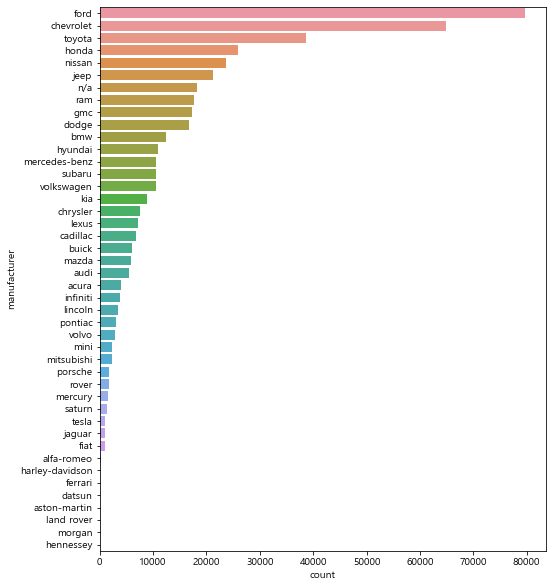

In [21]:
# manufacturer 시각화
countplot('manufacturer')

In [22]:
df.columns

Index(['region', 'price', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'age'], dtype='object')

#### 2) model

In [23]:
len(df['model'].value_counts())

31520

In [24]:
# length가 너무 긴 데이터의 경우 value_counts()를 해도 전체 데이터를 출력해주지 않는다.
df['model'].value_counts()

f-150                       8370
silverado 1500              5964
1500                        4211
camry                       4033
accord                      3730
                            ... 
dart sxt 4dr sedan             1
century custom 4dr sedan       1
sienna le 8 passenger          1
soul base 4dr crossover        1
caravana                       1
Name: model, Length: 31520, dtype: int64

In [25]:
# for문을 활용해 전체 내용을 출력할 수 는 있다.
# 모델명 : df['model'].value_counts().index
# 모델 별 숫자 : df['model'].value_counts()
for model, num in zip(df['model'].value_counts().index, df['model'].value_counts()):
  print(model, num)

f-150 8370
silverado 1500 5964
1500 4211
camry 4033
accord 3730
altima 3490
civic 3479
escape 3444
silverado 3090
explorer 2941
equinox 2923
corolla 2801
wrangler 2788
mustang 2652
malibu 2649
tacoma 2649
fusion 2608
grand cherokee 2574
focus 2491
grand caravan 2445
2500 2438
tahoe 2266
cr-v 2230
impala 2127
cruze 2125
sonata 2062
elantra 2010
sentra 1914
jetta 1870
prius 1863
rav4 1832
odyssey 1831
outback 1791
silverado 2500hd 1780
edge 1735
charger 1718
sierra 1500 1696
rogue 1687
forester 1514
traverse 1489
camaro 1472
pilot 1441
wrangler unlimited 1412
3500 1396
suburban 1381
f-250 1357
corvette 1345
sienna 1328
highlander 1318
f150 1311
acadia 1308
tundra 1302
soul 1294
sierra 1272
cherokee 1220
f-350 1164
journey 1117
passat 1098
town & country 1091
taurus 1091
4runner 1080
optima 1073
expedition 1073
challenger 1005
impreza 1004
murano 997
300 992
fusion se 966
colorado 960
enclave 957
c-class 952
escalade 930
pathfinder 914
durango 910
sorento 908
200 907
ranger 902
liberty 86

330ci 41
charger r/t sedan 4d 41
pathfinder le 41
belair 41
silverado 2500hd ltz 41
sonic rs hatchback 41
benz sl500 41
wrangler unlimited sport v6 automatic hard top 41
f-type 41
spectra ex 41
coronet 41
tahoe lt 4x4 41
a4 2.0t premium plus 41
flex limited awd 40
4500 40
oldsmobile cutlass 40
prius ii 40
corolla im hatchback 4d 40
f150 lariat fx4 4x4 1/2 ton 40
passat tdi 40
silverado ltz 40
lacrosse premium 40
2500hd 40
crv lx 40
clk-class 40
escape xlt 4x4 40
enclave cxl awd 40
topkick 40
envoy slt 40
cougar 40
captiva sport fleet 40
olet Silverado 2500HD 40
milan premier 40
q7 3.0t prestige sport 40
silverado 2500hd duramax 40
journey crossroad 40
benz gl450 40
2500hd high country 4x4 40
200 lx 39
650i 39
versa sv sedan 4d 39
transit 150 39
suzuki sx4 39
sonata sport 39
1500 st 39
SCION XB 39
tacoma access cab 39
q70 39
model x 75d sport utility 39
s60 t5 39
3500 laramie 39
lr2 39
s60 t5 sedan 4d 39
Genesis G80 39
compass limited 39
renegade sport 39
civic ex-t 39
legacy 2.5i 39
si

golf tsi s hatchback 21
pacifica limited 21
cls550 21
tribeca limited 21
rx 350 awd 21
malibu lt 1lt 21
e320 21
versa sr sedan 4d 21
pt cruiser convertible 21
e350 cutaway 21
crown victoria lx 21
q45 21
cobalt ss 21
sienna le awd 21
zephyr 21
silverado 2500 ltz lo 21
fleetwood brougham 21
rogue awd 21
Isuzu Rodeo 21
charger srt8 21
forester 2.5 x 21
f-150 lariat 4x4 21
juke sv 21
avalon xle 21
International 4400 DT466 21
ISUZU NPR 21
ranger supercab xlt 21
SUZUKI SX4 21
1500 big horn 4x4 21
express 3500 van 21
tundra crewmax trd pro 21
defender 21
1500 laramie longhorn 21
gmt-400 21
sonata limited 2.0t 21
2500 quad cab 21
civic lx sedan 4d 21
viper 21
a6 quattro 21
silverado 3500 lt crew cab 4x4 duramax diesel 21
sport hse 21
f-250 lifted crew cab lariat 4x4 powerstroke diesel 21
cl 21
isuzu rodeo 21
rav4 4wd 21
2 20
santa fe se 20
sable ls 20
insight hybrid 20
a4 2.0t premium 20
hardtop 2 door 20
INTERNATIONAL 4300 20
xts premium collection 20
f150 platinum 4x4 20
gladiator rubicon pi

3 series 328i xdrive sport 12
discovery sport se 12
fx35 awd 12
rdx sh-awd w/tech 12
jetta 2.5 se 12
q5 2.0t premium plus 12
cabriolet 12
cummins 12
silverado ltz 1500 12
500c 12
azera sedan 4d 12
f150 platinum 4x4 1/2 ton 12
1500 limited 4x4 gas 12
versa note s plus 12
borrego 12
new sierra 1500 12
matrix xrs 12
300d 12
f-250 crew cab xl 4x4 12
accord cpe 12
renegade latitude 4x4 12
240d 12
escape hybrid awd 12
deville dhs 12
cla-class cla 250 12
1500 limited 12
impreza outback sport awd 12
3 series 335i xdrive 12
maxima gle 12
captiva ltz 12
cx-5 grand touring awd 12
avalon touring 12
200 200c sedan 4d 12
sierra duramax 3500 denali 12
brz limited 12
equus signature sedan 4d 12
tundra trd off road 4x4 12
500l trekking hatchback 4d 12
benz cls63 amg 12
f350 king ranch 12
a8l quattro 12
rdx sh-awd 12
gr supra 3.0 premium 12
deluxe coupe 12
f-150 xlt crew cab short b 11
silverado 2500 high c 11
tacoma v6 2dr xtracab v6 1 owner * under 100k miles * locking differential * trd off road* tim

benz c230 sport 8
malibu ltz sedan 4d 8
tiguan 2.0t se 8
silverado diesel 3500 8
camry solara sle 8
q5 hybrid prestige sport 8
escalade esv luxury co 8
tribute s 8
quest se 8
police interceptor 8
countryman cooper hatchback 8
promaster city wagon slt 8
equinox lt2 8
911 2dr cabriolet carrer 8
prius one 8
yukon slt 4x4 gas suv auto 8
montero sport xls 7
beetle 2.0t final 7
Mack CTP713 7
hino 338 7
ml 350 4matic 7
mazda3 i sport manual 6-spd 7
murano le awd 7
s-10 blazer 7
silverado 4wd 7
niro lx wagon 4d 7
rebel 7
genesis 3.8l 7
civic sport hatchback 7
cr-z ex 7
435i m sport package 7
corvette base 7
gl350 bluetec 7
super duty f-250 srw lariat 7
tundra sr 7
volt premier 7
acadia slt2 awd 7
isuzu ascender 7
3500hd crane utility 7
silverado 1500 crew 4x4 7
suburban 2500 4x4 7
a6 premium plus 7
s500 7
camry se sport 7
tahoe ltz 3rd row 4wd 7
saab 900 turbo convertible 7
mdx sh-awd w/tech awd suv 7
s10 zr2 7
odyssey ex-l w/dvd 7
caddilac deville 7
f150 regular cab stx pickup 7
crx 7
f450 cr

sienna se premium 5
g6 gt sedan 5
freestyle 7 passenger 5
rsx type s 5
renegade latitude 4x4 gas 5
corvette 2lt 5
w5500 5
Mitzubishi Endeavor 5
malibu 4dr sdn ls w/1ls 5
FREIGHTLINER Thomas 5
escape fwd 4dr s 5
5 series 530i xdrive 5
435i xdrive 5
versa sedan sv 5
r500 5
outlander limited 5
f-150 extended cab 5
saab 900 5
odyssey ex-l dvd 5
f-150 supercab 5
camaro 1ss 5
g5 coupe 5
f550 contractors utility 5
grand cherokee altitude 4x4 5
tundra limited 4dr 5
yukon xl sle 5
x5 xdrive awd v8 suv 5
silverado 3500 crewcab 5
300 touring rwd 5
acadia slt-1 awd* captains chairs* 3rd row seating* leather* heated seats* lanekeep* collision avoidance * 5
300 lx 5
1 5
express 3500 cutaway 5
tahoe 4wd 5
sebring sedan limited 5
gs 450h sedan 5
canyon sle crew cab 5
odyssey ex-l w/navi 5
accord sedan lx 1.5t 5
cummins 2500 5
tundra sr5 crew cab 5
s60 t5 premier 5
regal sportback 5
2500 diesel 4x4 5
e350 super duty cutaway 5
silverado 35 5
xts platinum 5
6 series 640i gran coupe 5
2500 cargo 5
silvera

3500 drw 3500 4
fastback 2 door w trunk 4
mdx w/technology pkg 4
4runner trd off road 4
tiguan 2.0t se sport 4
insight lx 4
sq5 3.0t premium plus 4
ridgeline 4x4 4
evoque s 4
santa fe ultimate 2.0 4
studebaker commander 4
e 250 4
optima plug-in hybrid ex 4
e350 shuttle bus 4
outback 3.6r 4
f-350 crewcab lariat 4x4 drw 4
silverado 1500 ls z71 4
davidson fltru / road gli 4
town+and+country 4
atlas 3.6l v6 se 4motion 4
cube van srw just 10k miles one owner 4
el dorado 4
2008 4
taurus sel *fr $499 down guaranteed finance 4
frontier pro-4x 4
focus s sedan 4
taurus station wagon 4
c250 sport 4
f-150 xlt *fr $499 down guaranteed finance 4wd 4
cr-v se awd 4
several 4
encore leather sport 4
silverado ld 4
dakota quad cab 4x4 4
olet Silverado 3500HD CC 4
x3 3.0i x drive 4
hardbody 4
mks ecoboost sedan 4d 4
avenger mainstreet 4
sienna le 7 passenger 4
Freightliner Cascadia 125 4
1500 4wd mega cab 160.5" slt 4
smart fortwo pure 4
968 4
monte carlo 2dr cpe lt 3.9l 4
tlx 3.5l v6 sedan 4
cooper s 2dr

f-350 supercab 3
CAMRY 3
starchief 3
Corvette Convertible 3
lamborghini gallardo 3
santa fe sport 2.4l auto 3
scion xb automatic 3
1994 3
town and country touring 6-speed automatic 3
liberty sport *fr $399 down guaranteed finance! 3
corvette v8 targa 3
benz gl350 blutec 3
pathfinder sv sport 3
jetta s 6-speed automatic 3
forte ex *fr $499 down guaranteed finance 3
escape 4wd 4dr se 3
cooper roadster 3
envoy slt 4wd 3
Mack GU713 3
wrangler 4.0l 3
3500 ltz 4x4 3
328i x drive coupe 3
wrangler sport suv 3
E350* *E-350* Box Truck 3
equinox lt *fr $499 down guaranteed finance 3
benz e350 4 matic 3
ROLLS ROYCE GHOST 3
cheverolet trailblazer 3
capri convertible 3
fusion *fr $499 down guaranteed finance 3
trax lt *fr $499 down guaranteed finance awd 3
accord ex v-6 coupe at automatic 3
traverse lt *fr $499 down guaranteed finance awd 3
e430 3
sorento l suv 3
Kia-Hyundai-Toyota Tacoma-Subaru 3
2500 silverado lt 4x4 3
tahoe *lt *$499 down guaranteed finance 3
beetle-classic 2.5l pzev 3
promaster 

mustang gt coupe boss 302 3
1500 express 4x4 gas 3
hr-v lx awd 3
is 300 base 3
v90 3
PT Cruiser 3
amg gt63 1 owner 3
truck big block 396 3
crosstrek 2.0i sport 3
f-250 superc 3
sprinter crew van 3
s55 amg 3
forte great deal lx 3
3500 slt dually 3
impreza hatchback 3
e350 15-passenger van 3
s 10 3
cruze great buy lt 3
yukon xl slt automatic 3
gti se 3
sportage lx awd gas suv auto 3
tacoma trd sport crew cab 3
ctsv 3
300 4dr sdn 300s awd 3
tucson sel plus 3
accord ex-l fwd gas coupe 3
3-series 330i xdrive 3
q50 premium awd 3
1500 promaster van 3
grand cherokee limited automatic 3
falcon wagon 3
elantra sdn 3
genesis 5.0 r-spec sedan 3
benz e500 sport 3
navigator luxury 3
sprinter 350 3
tucson 26,000 miles 1 3
freightliner fl60 3
nx 200t fwd 4dr 3
escape xlt sport 4-cyl 2.5l 3
tacoma prerunner double c 3
sienna se 8-passenger 3
benz 300d 3
Bentley Continental GT V8 S 3
cirrus 3
passat gls tdi 3
gti wolfsburg edition 3
edge 62,000 miles awd 3
G37s 3
silverado 3500 work truck 3
titan king c

sprinter 3500 ext 2
cherokee wd dr overland 2
dts premium 3 2
Hino 258lp 2
seirra 1500 2
Hino 258LP 2
f-250 super duty king ranch 2
dakota slt 4x4 4 door 2
eaquinox lt awd 2
silverado 1500 lt crew cab 2
tacoma 4x4 trd sport 2
Suzuki SX4 Base AWD Wagon 2
taurus sel fwd gas sedan 2
xc70 t5 drive-e premier 2
Truck Boxes 2
journey se 3rd row 2
POLAIRS RZR XP 4 1000 HIGH LIFTE 2
BAJA OUTLAW 2
POLARIS RANGER RZR 900 2
POLARIS 900 S 2
dakota magnum 2
Silverado 2500 2
4400 2
escape se 4wd suv 2
mirage es hatchback 2
1500 slt crewcab 2
transit connect swb xl wrear liftgate 2
equinox 2lt awd! awd 2
f150 tuscany 2
s40 t5 r-design 2
1500 bighorn rwd gas 2
f150 raptor 4x4 1/2 ton 2
benz e400 2
CAN AM SPYDER ROADSTER 2
REAR ENTRY HANDICAP VAN 2
650xi 2
mga 2
1 ton cargo van 2
OLDSMOBILE AURORA 2
silverado c3500 2
2500 big horn crew cab 4x4 shortbed 6.4 liter 410hp v8 2
rav 4 limited awd 2
rav4 v6 limited 2
silverado 2500hd ext cab 2
altima . sr sedan 2
standard 2
f15o lariat 4x4 crew 2
big horn 4x4 

128 2
silverado 1500 ltz crew cab 4wd 2
transit t-250 cargo 148" ex 2
OTHER CTS 2
Freightliner M2 Dump Truck 2
f350 utility service truck 2
sorento 4wd 2
outback sport sp ed 2
nissian pathfinder se 2
grand cheerokee laredo 4x4 2
lancer evolution mr 2
chryler town and country lx 2
saab 9-3 linear turbo 2
davidson tri glide ultra 2
compass latitude sport 2
superchar 2
pathfinder sv 4x4 gas suv 2
odyssey ex-l wheelchair van vmi northstar - power infloor ramp side loading conversion 2
town and country lxi 2
econoline commercial cutaw 2
spectra gsx 2
silverado 2500 crew cab 2
Cars,Trucks,Vans,Suvs 2
patriot 4x4 sport 2
sierra 1500 4x4 1/2 ton gas 2
s5 cabriolet quattro 2
chrylser 300 2
International Durastar 4300 Alte 2
lcf4500 2
silverado2500 2
compass trailhawk 4x4 w/ 2. 2
silverado 1500 double cab 4wd 2
tahoe yukon 2
lifted expedition platinum 2
sorento awd lx 2
Civic 2
mk ix 2
grand caravan sxt wheelchair van vmi verge ii - manual fold out ramp rear loading conversion 2
gs450h 2
express

1500 express quad cab 4x4 2
LAMBORGHINI HURACAN 2
nv3500 hd cargo 2
versa note sl 2
tribute 4x4 2
f250 4x4 ranger - big 2
3 series 328xi awd 4dr seda 2
b-class electric 2
KENWORTH BOX TRUCK 2
odyssey ex- 2
Plymouth Fury II 2
qx60 luxe 2
CX-9 2
cherokee altitude sport 2
challenger sxt 2dr coupe v6 3.6l 305hp 2
q7 premium plus luxury suv 2
explorer sporttrac 2
camey 2
xts awd 2
highlander platinum 2
5-series 530i 2
f150xl 2
Truck 2
c6500 topkick 2
f-150 5.0l v8 4x4 2
Kenworth T880 2
Mack Granite 2
sentra fe+ sv 2
f-350 lariat diesel 2
sonata sel sedan 4d 2
sport v8 2
q50s 2
model tt 2
international dump truck 2
Hudson Hornet 2
e-250 cab van 2
camry xle hybrid sedan 4d 2
John Deere Loader 2
genesis 5.0l r-spec 2
xc60 fwd 4dr t5 drive-e platinum 2
2015 MUSTANG CONVERTIBLE PREMIUM 2
xv crosstrek hybrid one owner 2
forester 2.5x premium one owner 2
aramada 2
international 4200 vt365 2
is 250 base 4dr sedan 2
3.0 cl 2
e-350 super duty xlt 2
1500 4wd crew cab 140.5 big 2
benz slk 32 amg 2
SPOR

cayenne turbo diesel premium 1
500 2dr hb pop 1
AA 1
plymouth sedan deluxe 1
Homemade flatbed 1
Homemade utility 1
f-350 super duty xl 4dr crew cab xl lariat 1
62 Corvette Hard Top Convertible 1
gs350 convertible 1
Homemade Utility 1
Cheverolet Traverse LT 1
6s gt 1
gls550 1
12.6 X 5.6 1
bighorn 1500 1
325xit 1
s8 t6 1
jetta 2.5s sportwagen 1
wrangler jk rubicon 1
2018 camaro 1
cts-v sport 1
pilot ex-l w/ navi 1
2008 Allianz 3000 Sweepster 3000 1
f-150 lariat 4x4 ecoboost 1
forestor 1
vanagon "l" 1
durango slt adventurer 1
frieghtliner MT45 1
f250 platinum 4x4 1
volkswagon cc lux 1
Hyndai Elantra Value Edition 1
sorento ex automatic 1
88 Suzuki Samurai 1
passat se 1.8t 1
corvette coupe lt1🌟 1
Corvette Stingray 1
tl tech sh-awd 1
mkiv gti 1
sierra 2500hd work truck 2dr 1
c250 coupe 1
routon se 1
535d xdrive m sport 1
q5 quattro premium plus awd 1
tundra double cap 1
f-250 xlt hd 1
juke fwd sv 1
vanagon doka 1
equinox awd 2lt 1
Isuzu P'up Diesel 1
b350 cargo van 1
rav4 hybrid le awd (nat

v8 supercharged rwd 1
sequoia platinum i-force ffv 4x4 1
grand caravan v6 se 1
grand cherokee overland edition 4x4 v6 1
Scion tC RS 7.0  FWD 1
mdx awd touring v6 1
cruze ls fwd i4 turbo 1
Suzuki Grand Vitara Ultimate Adventure 1
yaris le auto 1
323 convertible 1
edge sel awdcrossover 1
elantr limited 1
astre 1
z4 2.5i-convertible 1
gl 450 4matic-navi-camera 1
focus se-hatchback 1
express passenger lt 35003dr-extended passenger 1
silverado 2500 lt-crew cab 4x4 1
f-150 xl 4x4 supercab 1
vt1100c (shadow spirit 110 1
F350 Powerstroke Diesel 1
elantra sel 2.0l auto s 1
bug (vintage) 1
3-series 330xi 1
tucson gls-awd 1
2 door deluxe 1
2.3cl 1
OLDSMOBILE BRAVADA 1
mks eco-boost 1
accent 3dr hb auto gs 1
town country swb 1
explorer xls 4dr suv/4x4 1
saab 9-3 sport combi 1
soul ev wagon 4d 1
cc 2.0l 1
1500 plow truck 1
tiguan tsi awd 1
f-450 dump/plow truck 1
Dogde Grand Caravan 1
525i xdrive awd 1
fusion 2.5 se 1
CHARGER 1
2015 Taurus interceptor 1
NISSANA  SENTRA  GXE 1
savana explorer limite

Smart ForTwo Passion Cabriolet 1
C5 Corvette Convertible 1
benz glc 300 suv 1
318i/325i 1
explorer 4x4 eddie bauer 1
armada platinum automatic 1
f-150 king ranch automatic 1
Peterbilt 348 1
Versa note sv 1
e46 1
corolla le premium 1
sonata sport automatic 1
tahoe ls automatic 1
Can Am Maverick Max 1000cc Turbo 1
corolla xse fwd gas auto 1
soul base automatic 1
sentra 1.8 sl 4dr,spoiler 1
se convertible 1
super duty f-350 srw xl automatic 1
durango sxt automatic 1
explorer st 4x4 gas suv 1
firebird 1988 1
2017,16,15, Some 2018 Models 1
gx gx 460 premium automatic 1
town and country fully 1
super duty f-350 crew cab 1
truck ranger 1
hyundia 1
f150xlt v8 ext cab pick 1
stealth rt/tt 1
k1500 crew 4x4 w/t 1
i3 base 1
TEXAS PRIDE 30' 1
1500 rebel crew cab 1
Corvette ZR1 1
2003 corvette 1
2500 crew cab diesel 4x4 1
invicta 1
focus sel fwd gas hatchback 1
plymouth fury 1
eclipse cross awd le 1
g10 deluxe van 1
335is convt 1
r10 1/2 ton p/u 1
international travelall 1
Chysler imperial 1
f150 ex

jetta sedan 2.0l tdi 1
macan s sport chrono pa 1
Freightliner Day Cab 1
sentra 2017 1
f150 fx4 6 1|2 ft 1
mazda3 5-door grand touri 1
accord exl 2d 1
camaro lt 2d 1
camaro ss 2d 1
lada 1
tl 3 1
mustang ecoboost convertib 1
accord ex-l v6 auto 1
cr-v 4wd 5dr ex-l 1
accord lx 1.5t cvt 1
e-class e320 1
x3 xdrive28d driving assist 1
x3 xdrive28i sports activit 1
xl 883 1
500c 2dr conv pop 1
dart 4dr sdn aero 1
rx rx 350 awd 1
3.0i 1
cr-v awd 5dr ex-l w/navi 1
xc60 3.0t 1
escalade awd 4dr luxur 1
trax awd 4dr ls 1
passat r-line w/comf 1
cr-v 2wd 5dr ex-l 1
Orion BUS 1
soul ! auto 1
freightliner lt 70 1
expedition el 2wd 4dr limi 1
highlander limited plati 1
rav 4 suv 1
new beetle 2dr manua 1
wrangler 2d sport utility x 1
escape 4dr 103 wb xlt choi 1
mpv minivan 1
maserati ghibli sq4 1
sierra 1500 4wd double cab 1
lr3 4wd 4dr v8 se 1
silverado 1500 4wd cr 1
tiguan 2.0t sel 4mot 1
atlas 4motion 3.6l v 1
Tayota Prius 1
enclave cxl-2 awd 6-speed automatic overdrive 1
d150 w150 1
odyssey,touring

25ix 1
ssuzuki SX4 1
2500 hemi 1
f-350 xlt super cab 4x4 1
camaro 2ss convertible 1
Corvette Coupe 1
charger hellcat 1
super duty f-350 4x4 srw 1
2017  Jetta · 1.4T SE 1
ih travelall 1
highlander limited 4x4 v6 1
Taurus 1
430xi 1
f-150 larit 1
Kemworth T800 1
maserati levante 1
cj 3b 1
fushion sel 1
Crown Imperial 1
transit wagon low roof xlt 1
sc 3dr 1
f350 dump truck 1
l521 1
1997 F250 7.3L power stroke 1
sierra pickup truck 1
35th anniversery series 1
750 lix 1
Chevorlet equ 1
k 2500 1
silverado z71 lt 4wd 1
nova wagon 1
f250 super duty 4wd w/ plow 1
Suzuki Aerio 1
fit ex manual 1
colbalt ls 1
legacy se 1
forester 2.5 x awd 1
benz 300 se 1
liberty jet limited 4wd 1
l series wagon lw1 1
mirage g4 le 1
mirage g4 se 1
turbo 1
f 250 super duty crew cab 1
blazer k 1500 1
CORVETTE 1980 1
benze e320 1
c7h042 1
transit wagon 350 1
335i gt 1
Chev. Camaro Rs 1
liberty crd diesel 1
vega sedan delivery 1
f-250 light duty 1
outback impreza 1
320i x drive awd 1
fleetwood limited 1
jx 35 awd 1
ran

insight hybrid touring 1
4wd trucks 1
wrangler x tj 1
Tahoe 2000 1
200 convertible limite 1
impreza awd gas wagon 1
imiev 1
a3 3.2 quattro awd 1
tacoma lifted with brand 1
08CHEVY 1
acadia slt-1 fwd 1
liberty limited edition 4x4 1
is250 sport 1
lancer evolution gsr 1
Mercedes/Dodge Sprinter T1N 1
passat vr6 1
3500hd dually 1
435 1
3 series xlt 1
154683 1
g35x-sport v-6 3.5l awd 1
suburban 1500 awd 1
Nisan cube 1
jetta station wagon premium 1
750li luxury m-sport 1
maxima 3.5 sv w/premium 1
coupe john cooper works 2d 1
accord hybrid with navi 1
c-20 truck 1
2009 RABBIT 2.5 1
c750 1
patriot sxt 1
1998 Z28/SS SLP CAMARO 1
OTHER 17 FOOT BOAT 1
challenger titanium 1
yukon xlt 1
wrangler 4x4 2dr 1
sienna xle premium 8-pass 1
2005 mustang gt 1
impreza bad credit 1
cruze 1.4t lt 1
1994 Oldsmobile Cutlass Supreme 1
benz 280 slk 1
veloster bad credit 1
k20 truck 1
sport 325i 1
R 1
slr mclaren base 1
10 1
mkz reserve 4d sedan automatic 1
rdx base 4d sport utility automatic 1
mustang ecoboost prem

ranger f150 xlt 1
s countryman 69k mile 1
Cheverolet Corvette ZR1 1
ai Veloster 1
rx400h, 2wd, hybrid 1
f150 4wd f-150 truck 4x4 1
van xle 1
Romeo Stelvio 1
caddy deville 1
q5 tdi s-line 1
Cooper S Countryman 1
beetle *tdi* diesel 1
F-350  PLATINUM *4WD 6.7L *88K 1
c250 only 17k 1
Mercedez Benz C320 Sport 1
forte 4d sedan 1
xc60 t6 awd turbo 1
2007 Peterbilt 1
centra 1
santa fe. 2005 1
Bucik 1
MACK. CH 613 1
esv 1 owner 135k 1
tundra sr5 xsp 1
SUBURBAN  LTZ  5.3L  1 OWNER 1
ats 3.6l 94k clean 1
f-150 4wd 3.5l v6 1
vega wagon 1
328i like new* 70k mile 1
odyssey ex l w dvd 1
3500 tradesman crew cab 4wd 1
f250 sd supercab utility tr 1
2007 crysler 300 1
tuscon limited 1
Escape SE 1
avalanch 1
cv-r 1
econoline e150 van 1
K2500 SLE Z71 1
sunbird convertible 1
a4 convertible quattro 1
veracruz 2011 1
Cheverolet Corvette Z51 1
International4400 1
grumman olson workhorse Stepvan 1
grand cherokee limited x 1
odyssey minivan 1
beetle final edition sel 1
sl65 1
ats coupe luxury 1
firebird transam

Suzuki grand Vitara 4X4 1
2 door sedan coupe 1
super duty f-350 srw f350 1
335i m sport 1
prius hybrid xle awd 1
legact gt 1
mecury cougar 1
Special con. 1
wrx awd 6 speed 1
2014 coup 1
1970 Plymouth 1
1997 Astro van AWD 1
MG MGB Roadster 1
b150 1
f450 heavy duty 1
c34 hd 1
wrangler sport-x 1
328i gt 1
colorado lt v6 1
335i conv 1
Caddilac Escalade 1
Miles Electric series 40 1
Dymac Electric 48V pick up. 1
venza fwd v6 1
ats 4 - 2.0t 1
2011Ranger 1
s60 r 2.5t awd 1
soul gt-line turbo 1
q50 awd red sport 1
2-door coupe 1
2008 sti 1
corolla s. 1
Chrsler 200 Convertible 1
sierra c2500 1
ROLLS ROYCE silver cloud ll 1
Acterra, Sterling 1
2006 International 4200 1
f-150 lariat crew 5.5ft bed 1
f-150 2wd supercrew 145 xlt 1
contour se 1
odyssey touring elite whee 1
3500 cummins 4x4 1
2500 crew cab cummins 1
2500 4wd crew cab 149 larami 1
ciivic 1
Oldsmobile Vista Cruiser 1
sienna wheelchair handica 1
sorento ex v6 – awd 1
tacoma trd sport double c 1
sprinter passenger 2500 1
1500 crew cab 4x4

E350 AMG 1
convertible super beetle 1
grand caravan american value package 1
4500hd flat bed 1
blazer 4x4 ls 1
prius le 1
rs 7 1
c10 custom deluxe 1
valer 1
f450 super duty flat bed 1
e 2-50 1
320i sport 1
2002 A430 1
Willys Pickup Truck 1
panamera turbo s 1
silverado 2500hd long bed 1
12 MBZ sprinter 2500 170"W.B. 1
silverado crew 2500hd 1
f150 xl reg cab long 1
mbz sprinter 2500 standerd 144 1
silverado 2500 utility 1
f150 regular cab xl 1
transit t350 148"l/r 1
transit t350 low roof 1
express 2500 cargo racks and shelves! 1
express 2500 cargo metal shelves! 1
model 3 awd 1
f-150 raptor svt 1
f1 truck 1
cr-v ex-l fwd 1
alantra 1
FREIGHTLINER Sprinter Cargo Vans 1
lamborghini urus 1
sentra sr sedan 1
jetta 2.0 s sedan 1
mercedez benz cls63 1
Toyora highlander sport 1
passat wagon gls 1
altima gxe loaded 1
q5 premium 2.0t quattro tip 1
Lexus. Es300 1
transit t150 cargo van 1
ilk 1
rx450h l 1
Lexuses300 1
benz c 43 amg 4matic 1
c300 luxury 1
sequoia v8 1
benz gla 250 4-matic 1
430i spor

MCKENZIE LAKOTA 5TH 1
short bed 1
2500 hd slt 1
cherekee limited 1
300c leather navigation 1
grain truck 1
f=250 super duty 4x4 1
ecape se ecoboost 1
- g 37 1
E350 4 MATIC 1
ford/Brimar 1
2011 freightliner spinter 3500 1
Clean Civic 1
650 convertible 1
x5 sport package 1
c300 4matic amg package 1
sedan 210 1
p series 1
all types are years 1
romeo stelvio ti 1
q3 q5 q7 a3 a4 a5 a6 a7 1
silverado 2500 high co 1
yukon xl denali 6.2l 4x4 1
1500 express 4x4 quad cab 1
sierra 2500 denali 4x4 6.6l 1
caddy 1
f-250 king ranch crew cab 1
sedan gasser 1
box truck 14 ft 1
sonata - gls 1
fit - lx hatchback 4d 1
accord - lx 1
sonic - rs 1
cooper 2dr hatchback 1
rav-4 awd sport 1
e-350 box/utility truck 1
s60 t6 awd 3.0 1
journey wagon 1
transit 2019 1
power mirrors power sunroof 1
cherokee limited 4.0 ho 1
ml63 amg 1
dakota bighorn 1
HUMMER H3T Alpha 1
jetta tdi 6 speed ma 1
colorado lt 4x4 long 1
x4 xdrive m sport package 1
1993 Isuzu NPR 1
2003 Freightliner FL 70 1
series 62 coupe 1
e450 box truck

volkwagen touareg 1
euro 1
550i x-drive 1
k1500 tahoe ls 1
genesis 3.8 sedan 1
duramax / allison 1
niro fe hybrid 1
g 55 amg 1
e550 1
yukon xl 1500 4x4 1
camaro iroc z 1
benz sl 55 amg 1
Linclon Continental CE 1
nc700x 1
oldsmobile alero gls 1
sprinter 2500 extended 1
acvord ex 1
Cavalier 1
335i turbo convertible 1
hr-v awd 1
ml 500 1
sentra 2.0 s 2007 1
tundra 4wd truck crewmax 1
72 Oldsmobile Cutlass Supreme 1
Mazda6 i grand touring 1
hyndai elantra unlimited 1
xc60 t6 platinum sport 1
town and countr touring 1
equinox 1lt awd 1
6-i 1
2006 MUSTANG convertible 1
1966 deville 1
dually 3500 sle 4x4 1
ct3 1
2008 International 1
vdp 1
Honda, Odyssey EXL 1
Plymouth   GTX 1
Isuzu Rodeo Sport 1
Isuzu Rodeo 4x4 Sport Amigo 1
1996  Corvette Grand sport 1
560-class 560 sl 1
electra 225 convertible 1
450sl convertible 1
other pickups 1
riviera gs 1
accord ex v-6 sedan 1
saab 9-3 aero convertible 1
plymouth laser 1
escape titanium, awd 1
titan ext cab le 1
CX-5 Grand Touring AWD 1
el camino class

Htundai accent 1
Ramber american 1
sierra 3500 dump w plow 1
2018 volkswagon Jetta R-LINE 1
golf wagon tdi 1
Kia-Subaru-Toyota-Ford F-150-VW 1
2003 SUZUKI GRAND VITARA 1
Londonderry 1
rav-4 limited awd 1
convertible 380sl 1
1500 laramie 5.4l 1
x3 4x4 1
envoy - 4x4 1
ecosport se awd 1
f150 xlt xtra cab 4x4 1
6 sedan 1
forester 2.5x 5-speed 1
encore leather awd 1
cooper clubman turbo 1
terrain awd 4dr 1
cherokee sport limited 1
fusion sel-sedan 1
2007 V70 Xc wagon 1
f-150 xlt 4x4 crew cab 1
benz s550 4matic coupe 1
International Harvester IH 1
f-150 limited crew 1
f-350 lariat dulley 1
400 convertible 1
Peterbilt 567 1
Coachmen 1
acyra RL 1
nv 2500 high roof cargo 1
carolla s 1
7400 1
international Durastar 7400 1
yaris se hatchback 1
MB c300 1
mk vii 1
ex37 1
2010--2015 Nissan,Ford,Chevy,Kia 1
terrain slt-2 awd 1
Merury 1
scottsdale pickup 1
1964 OLDS F-85 Wagon 1
boxster 2006 1
nvp 1
Mack Box Truck 1
330 cic 1
silverado 2500 hd crewcab 1
Simon duplex 1
95 Saab 900 S 1
4500 drw 1
2011 F

```python
countplot('model') 
```
으로 시각화를 하려 했으나, 데이터가 너무 커서 메모리상의 한계로 에러가 발생

- 각 모델명 별로 1개의 값이 있는 경우도 있다.
- 공백이 2칸 이상 있는 데이터 등 스크래핑을 통해 수집된 데이터로서 발생하는 몇몇 에러들이 보인다.

#### 3) condition

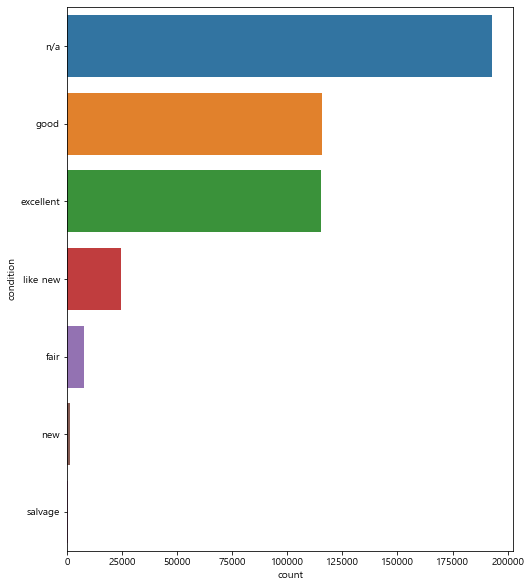

In [26]:
countplot('condition')

- salvage : 상태가 매우 안좋은 것을 의미
- n/a 값이 가장 많다. 
    - 차량 상태를 명확히 보여주지 않기 위해 입력 자체를 하지 않았을 가능성이 있어 보인다.
    - 차량 상태에 관련된 변수(age, odometer 등)를 통해 유추해서 채워넣는 등 전처리를 시도해볼 필요성 있음

#### 4) cylinders

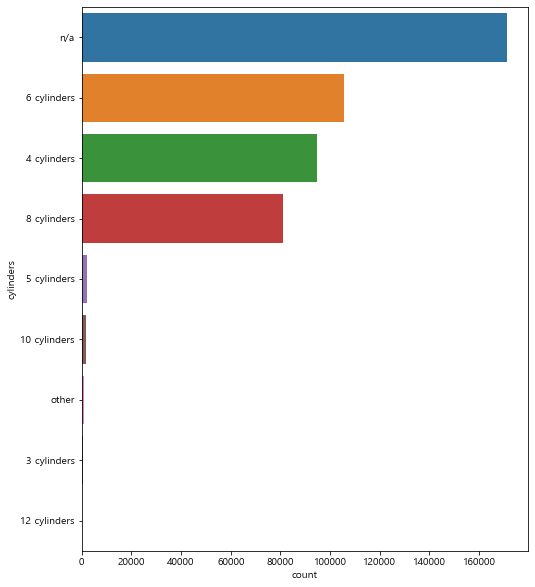

In [27]:
countplot('cylinders')

- n/a값이 대부분을 차지
- 여러가지 전처리 방식을 고민해볼 필요가 있다.
    - 데이터 수가 소수인 값들을 n/a에 포함시켜서 분석을 진행 하는 방식
    - n/a 데이터를 다른 컬럼으로 유추해서 채워넣는 방식

#### 5) fuel

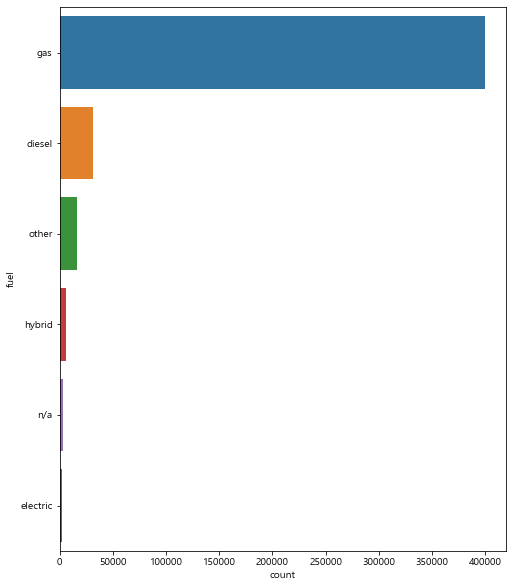

In [28]:
countplot('fuel')

- 대부분 gas 차량

#### 6) transmission

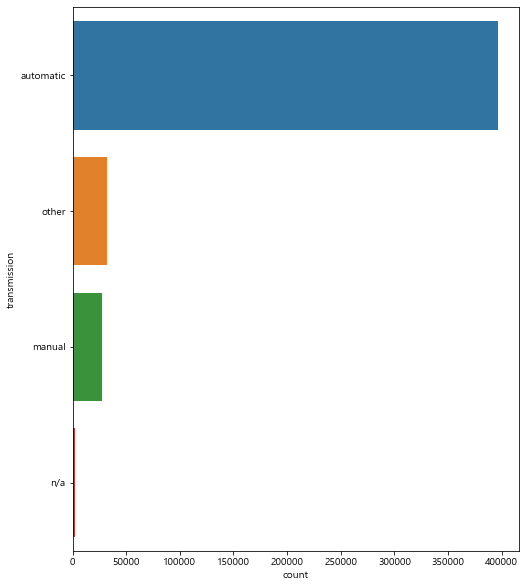

In [29]:
countplot('transmission')

- 대부분이 automatic 차량
- n/a값이 적어서 drop해도 분석에 지장 없을 듯

#### 7) drive

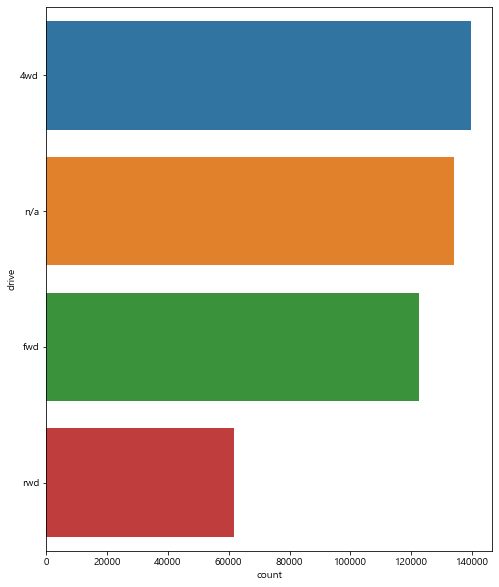

In [30]:
countplot('drive')

- 전반적으로 데이터 분포가 고른편
- 별다른 전처리 없이 학습시켜도 될 듯 하다.

#### 8) size

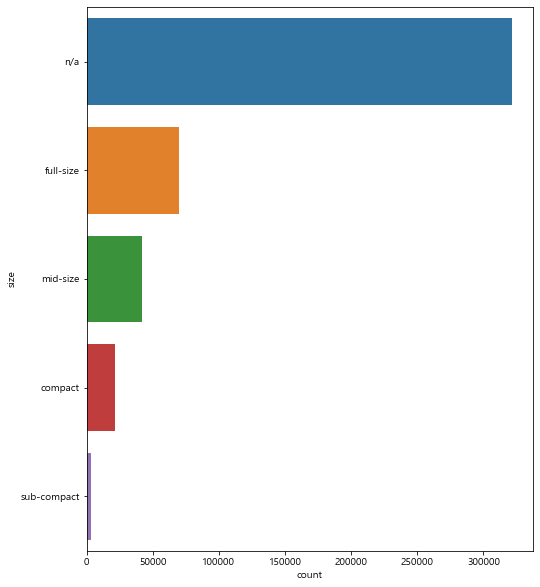

In [31]:
countplot('size')

- n/a가 가장 많다.
- 통계적 분석 결과에 따라 유의미할 것으로 판단되면 사용하되, 그렇지 않으면 제거하는 것을 고려

#### 9) type

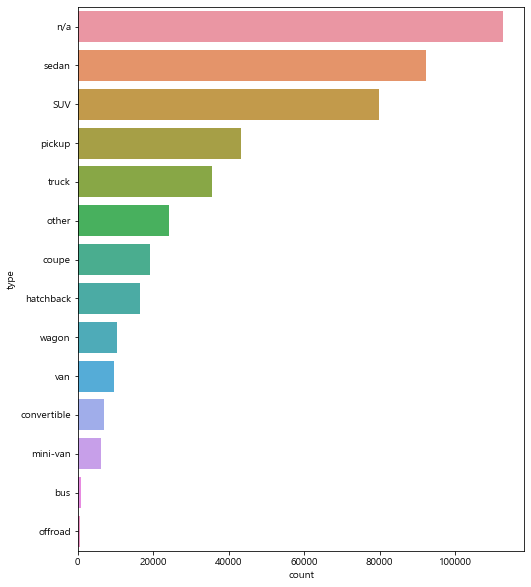

In [32]:
countplot('type')

- n/a가 가장 많다.

#### 10) paint_color

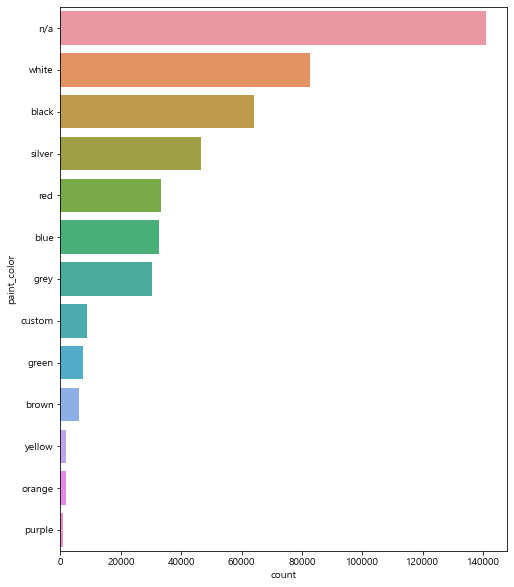

In [33]:
countplot('paint_color')

- n/a값이 가장 많다.
- custom에 따른 가격차이를 확인해볼 필요 있음
    - custom은 취향 차이에 따라 호불호가 갈릴 수 있을 것 같음.(=어떤 의미론 유의미한 값이 될 가능성이 있음)

### 수치형 데이터 분석

- 데이터의 범위가 너무 넓고 많은 경우 histplot은 ram할당량 초과로 연산이 안되는 경우가 많다.
- 특히, price의 경우 df.describe()로 확인했을때도 데이터의 분포가 이상할 것으로 예상되었다.

#### 1) price

<AxesSubplot:xlabel='price'>

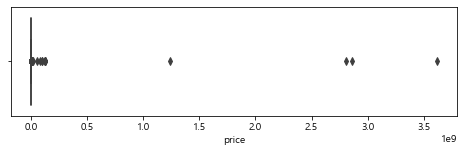

In [34]:
fig = plt.figure(figsize=(8, 2))
sns.boxplot(x='price', data=df)

- boxplot으로 보기엔 데이터의 분포등을 확인하긴 어렵다.
- outliers가 상당히 많다는 것은 대략적으로 파악 가능하다.
- 이럴땐 rugplot(x,y축 기반 주변 분포도, 개별 데이터 위치 파악 용이)으로 시각화 해보는 것이 데이터 분포 파악에는 더 유용하다.

<AxesSubplot:xlabel='price'>

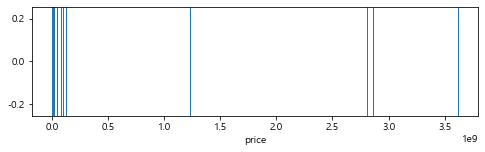

In [35]:
fig = plt.figure(figsize=(8, 2))
sns.rugplot(x='price', data=df, height=1)

- 1e9(10의 9승) 인 outlier는 제외하더라도, 데이터가 한쪽에 너무 치중되어 있어 유의미한 통계적 의미를 찾기가 어렵다.

#### 2) odometer
- df.describe()로 봤을때, 이상치로 예상되는 값의 크기가 상당했다.

<AxesSubplot:xlabel='odometer'>

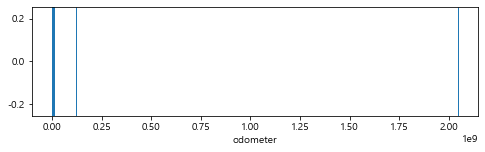

In [36]:
fig = plt.figure(figsize=(8, 2))
sns.rugplot(x='odometer', data=df, height=1)

- 1e9(10의 9승) 인 outlier는 제외하더라도, 데이터가 한쪽에 너무 치중되어 있어 유의미한 통계적 의미를 찾기가 어렵다.

#### 3) age

<AxesSubplot:xlabel='age', ylabel='Count'>

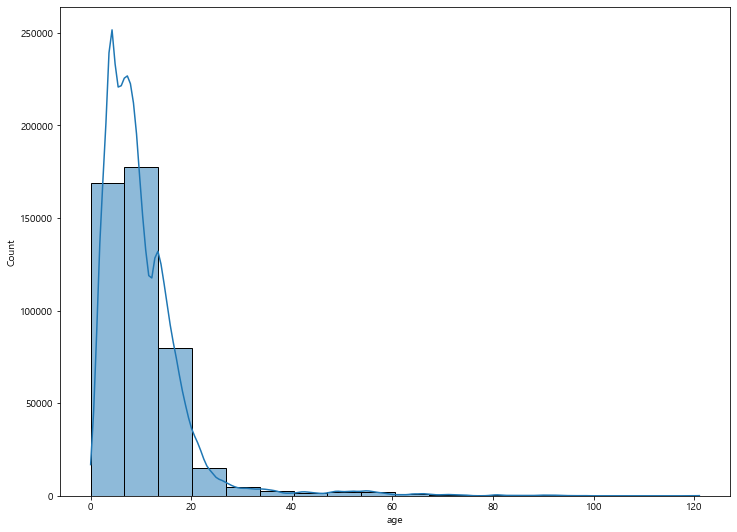

In [37]:
sns.histplot(x='age', data=df, bins=18, kde=True)

- 5 ~ 10년 정도 된 차량이 가장 많은 분포를 보인다.

## 데이터 클리닝

### 범주형 데이터 시각화 & 분석

- 범주형 데이터 x price 의 연관성 분석

<AxesSubplot:xlabel='manufacturer', ylabel='price'>

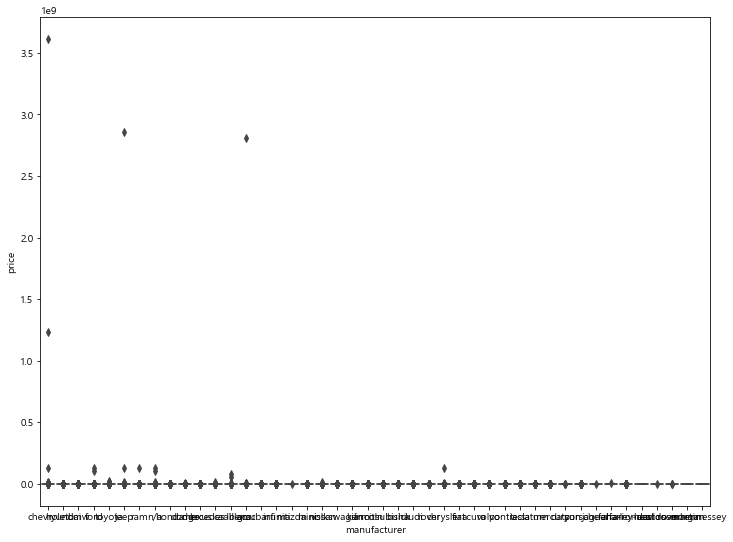

In [38]:
# Boxplot 계열로 범주형 데이터를 시각화하여 분석
# null값은 n/a로 채워서 확인
sns.boxplot(x='manufacturer', y='price', data=df.fillna('n/a'))

<AxesSubplot:xlabel='fuel', ylabel='price'>

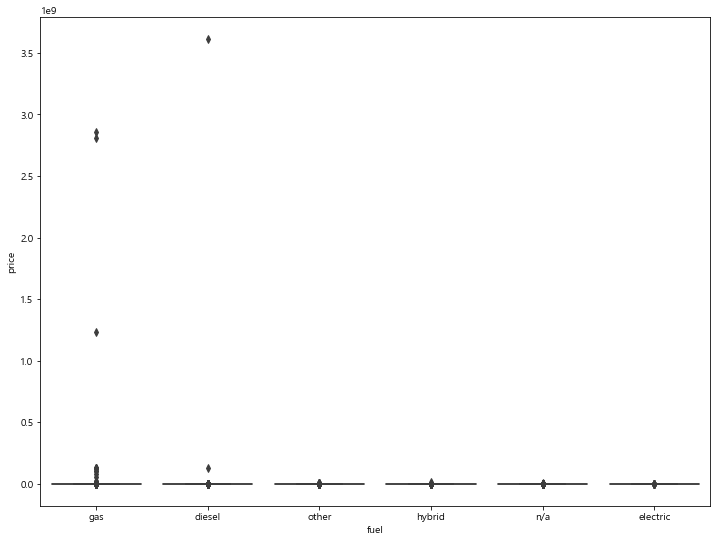

In [39]:
sns.boxplot(x='fuel', y='price', data=df.fillna('n/a'))

- 위에서 대략적으로 살펴보았듯이 n/a값이 너무 많거나, 데이터가 특정 범주에 몰려있는 경우가 많다.
- 이로 인해 시각화를 하여도 제대로된 분석을 하기가 어렵다.
- 데이터 클리닝을 통해 한번 정제해줄 필요가 있다.

### 범주형 데이터 클리닝

- 범주형 데이터(categorical)를 클리닝할 경우 보통 4가지 방법중 하나를 사용한다.
    - null 데이터가 포함된 row를 제거
    - null 데이터를 others로 치환하기
    - 너무 소수의 값만을 보유한 범주를 others로 치환하기
    - classifier를 학습시켜, null 데이터를 추정하여 채워넣기

#### 1) manufacturer

- 너무 소수의 값만을 보유한 범주를 others로 치환하기

In [40]:
# null값들을 others로 값을 부여 
# 시각화 , value_counts 등을 할때 제대로 결과가 나오도록 하기 위함.

# category 별 counts가 많은 데이터부터 내림차순으로 보여진다.
df['manufacturer'].fillna('others').value_counts()

ford               79666
chevrolet          64977
toyota             38577
honda              25868
nissan             23654
jeep               21165
others             18220
ram                17697
gmc                17267
dodge              16730
bmw                12352
hyundai            10975
mercedes-benz      10628
subaru             10510
volkswagen         10489
kia                 8854
chrysler            7499
lexus               7119
cadillac            6743
buick               6009
mazda               5931
audi                5583
acura               4008
infiniti            3714
lincoln             3338
pontiac             3037
volvo               2866
mini                2330
mitsubishi          2301
porsche             1779
rover               1662
mercury             1645
saturn              1393
tesla               1067
jaguar              1060
fiat                 955
alfa-romeo           187
harley-davidson      139
ferrari               96
datsun                63


In [41]:
# 범주형 데이터 시각화용 함수 생성
# 변곡점 그리는 함수 기본 설정은 convex
# 필요시 변경 가능
def viz_val_counts(col, shape='convex'):
    
    # 데이터 입력
    counts = df[col].fillna('others').value_counts()
    x = range(len(counts))
    
    # 변곡점(elbow point) 찾기
    from kneed import KneeLocator
    kn = KneeLocator(x, counts, curve=shape, direction='decreasing')
    
    # 격자 설정
    plt.grid(True, color='lightgray', zorder=0) 
    
    # 시각화
    plt.plot(x, counts)
    
    # elbow point 그리기
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='r')
    
    # elbow point 수치 표시
    plt.text(kn.knee+0.13, counts.median(), kn.knee, fontsize = 15, color='red')
    
    # 시각화한 범주형 변수들의 value_counts출력
    print(counts)

# 결과 확인용 value_counts 함수 생성
def val_counts(col):
    return df[col].value_counts()

- 각 컬럼(카테고리) 의 개수가 몇개인지 시각화 하는 그래프
- category 값이 너무 많기 때문에, 일일히 category명이 들어가도록 시각화 하면 데이터를 제대로 살피기 어려움
- 소수 값을 가진 category는 others로 치환할 것이기 때문에 변수명이 중요하진 않음
- elbow point(변곡점)을 시각화
    - others에 포함시킬 변수를 몇개로 정할지 참조할 때 사용.

In [42]:
def viz_val_counts2(col, num, shape='convex'):
    
    # 데이터 입력
    counts = df[col].fillna('others').value_counts()
    x = range(len(counts[:num]))
    
    # 변곡점(elbow point) 찾기
    from kneed import KneeLocator
    kn = KneeLocator(x, counts[:num], curve=shape, direction='decreasing')
    
    # 격자 설정
    plt.grid(True, color='lightgray', zorder=0) 
    
    # 시각화
    plt.plot(x, counts[:num])
    
    # elbow point 그리기
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='r')
    
    # elbow point 수치 표시
    plt.text(kn.knee+0.13, counts[:num].median(), kn.knee, fontsize = 15, color='red')
    
    # 시각화한 범주형 변수들의 value_counts출력
    print(counts)

- 데이터가 극단적으로 몰려있을때, 세부적으로 조정하여 보고자 할때 사용

ford               79666
chevrolet          64977
toyota             38577
honda              25868
nissan             23654
jeep               21165
others             18220
ram                17697
gmc                17267
dodge              16730
bmw                12352
hyundai            10975
mercedes-benz      10628
subaru             10510
volkswagen         10489
kia                 8854
chrysler            7499
lexus               7119
cadillac            6743
buick               6009
mazda               5931
audi                5583
acura               4008
infiniti            3714
lincoln             3338
pontiac             3037
volvo               2866
mini                2330
mitsubishi          2301
porsche             1779
rover               1662
mercury             1645
saturn              1393
tesla               1067
jaguar              1060
fiat                 955
alfa-romeo           187
harley-davidson      139
ferrari               96
datsun                63


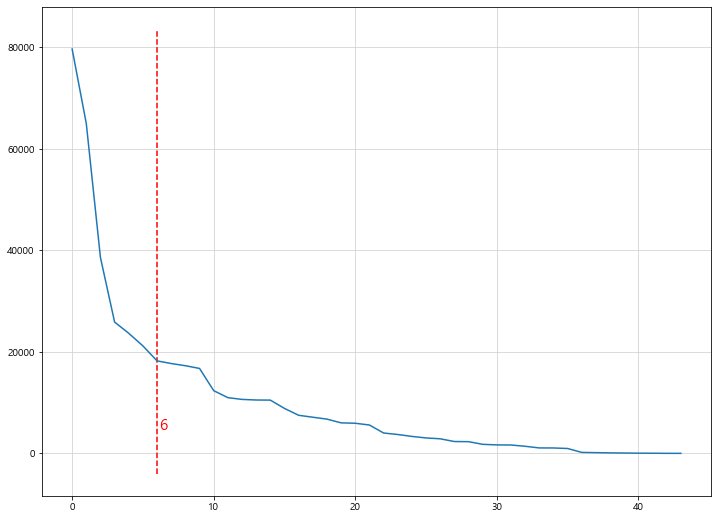

In [43]:
# 시각화 결과 
viz_val_counts('manufacturer')

In [44]:
# 해당 그래프의 category 명을 확인하고자 한다면 아래와 같이 확인 가능
# counts가 value_counts를 해서 내림차순 정렬된 것이기 때문에 앞에 나오는 값일 수록 데이터가 많은 것.
df['manufacturer'].fillna('others').value_counts().index

Index(['ford', 'chevrolet', 'toyota', 'honda', 'nissan', 'jeep', 'others', 'ram', 'gmc', 'dodge', 'bmw', 'hyundai', 'mercedes-benz', 'subaru', 'volkswagen', 'kia', 'chrysler', 'lexus', 'cadillac', 'buick', 'mazda', 'audi', 'acura', 'infiniti', 'lincoln', 'pontiac', 'volvo', 'mini', 'mitsubishi', 'porsche', 'rover', 'mercury', 'saturn', 'tesla', 'jaguar', 'fiat', 'alfa-romeo', 'harley-davidson', 'ferrari', 'datsun', 'aston-martin', 'land rover', 'morgan', 'hennessey'], dtype='object')

- 상위 10개의 데이터만 category로 남기고, 나머지는 others로 치환
- 급격히 감소하는 지점은 6개이지만, 범주값이 너무 적어서 10개로 지정

- others로 치환하는 함수 생성
```python
def to_others(col, n_categorical):
    counts = df[col].fillna('others').value_counts()
    df[col] = df[col].apply(lambda s: s if str(s) not in counts.index[n_categorical:] else 'others')
```

 - 위의 함수가 기본 형식.
 - 다만 유지해야할 범주의 개수보다 drop해야할 범주의 개수가 더 많을 경우 labmda 연산에서 counts.index[n_categorical:] 를 매번 불러오기 때문에 매우 오래 걸린다.
 - 따라서 미리 counts.index[n_categorical:] 를 변수화 하여 사용하면 메모리 부하를 줄일 수 있다. (아래 함수 참조)

In [45]:
# 지정한 개수 이외의 범주들을 others로 만드는 함수 생성
def to_others(col, n_categorical):
    counts = df[col].fillna('others').value_counts()
    others = counts.index[n_categorical:]
    df[col] = df[col].apply(lambda s: s if str(s) not in others else 'others')

- n_categorical에 others 포함 총 몇개의 범주변수로 만들 것인지 입력
- 시각화한 그래프로 확인한 변곡점을 기반으로 선택한 범주화의 값을 입력하여 변경

In [46]:
# 총 10개의 범주로 변경
to_others('manufacturer',10)

# 결과 시각화
val_counts('manufacturer')

others       134392
ford          79666
chevrolet     64977
toyota        38577
honda         25868
nissan        23654
jeep          21165
ram           17697
gmc           17267
dodge         16730
Name: manufacturer, dtype: int64

- 데이터의 구성이 클리닝 전에 비해 훨씬 단순해지고 깔끔해졌다.

#### 2) region

columbus               3818
rochester              3592
jacksonville           3504
springfield            3293
fayetteville           2990
                       ... 
siskiyou county          28
susanville               17
west virginia (old)      11
fort smith, AR           11
sioux city, IA            1
Name: region, Length: 405, dtype: int64


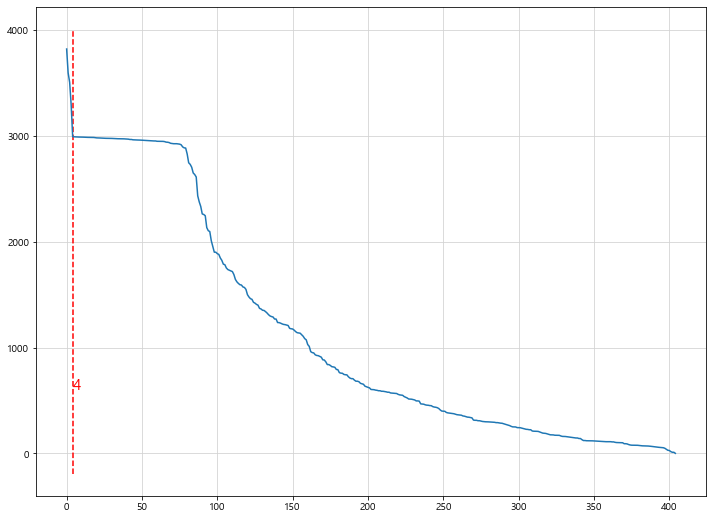

In [47]:
viz_val_counts('region')

- elbow point는 4, 상위 5개로 범주화
- 405개의 범주를 모두 사용하면 좋지만, 이 경우 차원의 저주 문제를 피하기 어려워 최대한 단순화 하고자 함.

In [48]:
to_others('region',5)

# 결과 확인
val_counts('region')

others          441016
columbus          3818
rochester         3592
jacksonville      3504
springfield       3293
fayetteville      2990
Name: region, dtype: int64

#### 3) model

f-150                 8370
silverado 1500        5964
others                4846
1500                  4211
camry                 4033
                      ... 
MG MGB Roadster          1
1997 Astro van AWD       1
rogue sv awd cvt         1
HUMMER H-3               1
caravana                 1
Name: model, Length: 31521, dtype: int64


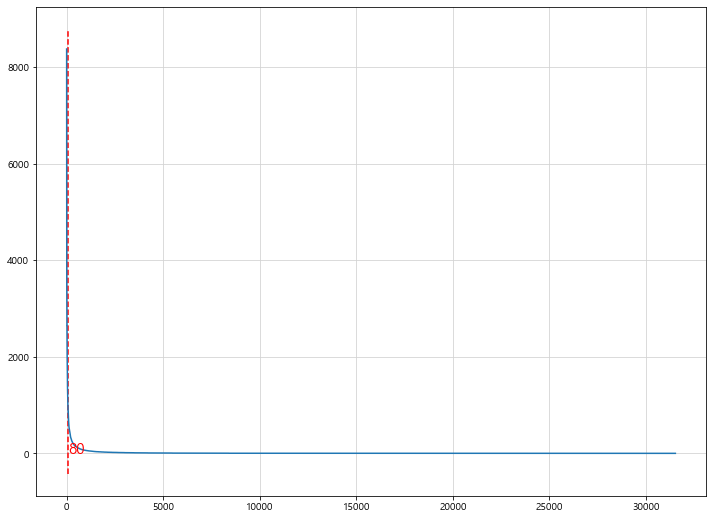

In [49]:
# raw 상태의 분포 확인
viz_val_counts('model')

- 분포가 매우 극단적 (상위 소수에 값이 몰려있다.)
- 조금 더 자세하게 들여다볼 필요가 있다.

f-150                 8370
silverado 1500        5964
others                4846
1500                  4211
camry                 4033
                      ... 
MG MGB Roadster          1
1997 Astro van AWD       1
rogue sv awd cvt         1
HUMMER H-3               1
caravana                 1
Name: model, Length: 31521, dtype: int64


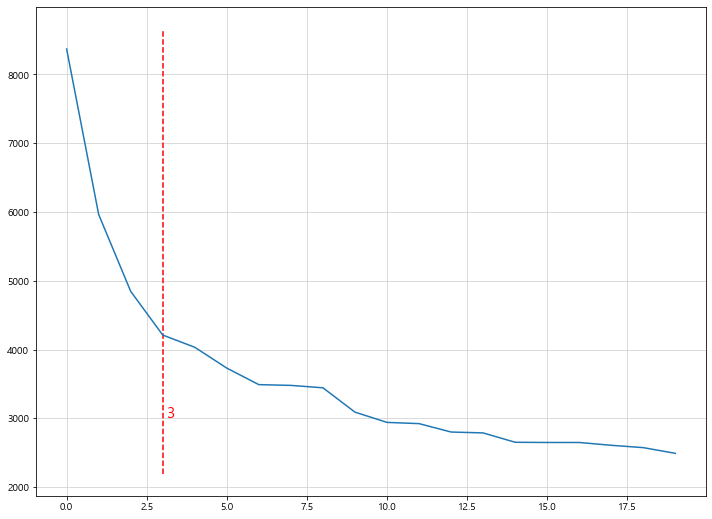

In [50]:
viz_val_counts2('model',20)

- 상위 20개 범주로만 봤을때의 변곡점은 3이지만, 최대한 많은 변수를 가져가기 위해 10개로 범주화
- 급격히 감소하는 구간을 거의다 포함할 수 있을 것으로 기대

In [51]:
to_others('model', 10)

# 결과 확인
val_counts('model')

others            413556
f-150               8370
silverado 1500      5964
1500                4211
camry               4033
accord              3730
altima              3490
civic               3479
escape              3444
silverado           3090
Name: model, dtype: int64

#### 4) condition

In [52]:
val_counts('condition')

good         115685
excellent    115206
like new      24553
fair           7740
new            1428
salvage         661
Name: condition, dtype: int64

- 변곡점에 해당하는 3을 기준으로 others 로 치환해도 될 것 같다.

In [53]:
to_others('condition', 3)

# 결과 확인
val_counts('condition')

good         115685
excellent    115206
others        34382
Name: condition, dtype: int64

#### 5) cylinders

others          171140
6 cylinders     105677
4 cylinders      94767
8 cylinders      81179
5 cylinders       2058
10 cylinders      1543
other             1112
3 cylinders        550
12 cylinders       187
Name: cylinders, dtype: int64


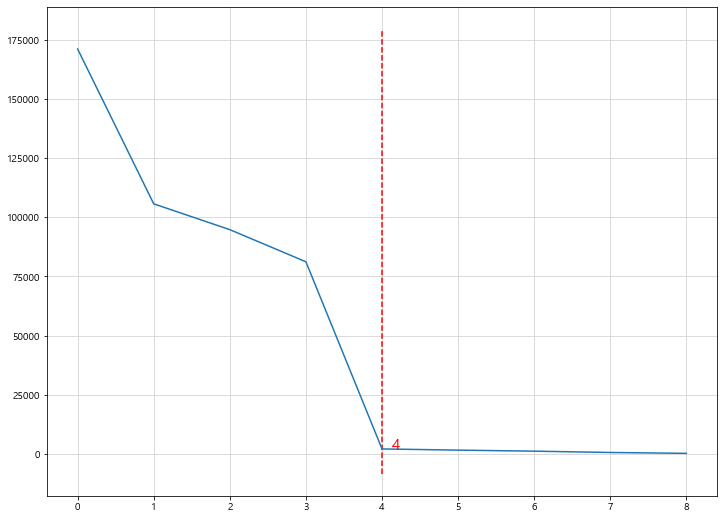

In [54]:
viz_val_counts('cylinders')

- 변곡점인 4부터 데이터 개수가 거의 같다.
- 변곡점을 기준으로 others로 치환한다.

In [55]:
to_others('cylinders', 4)

# 결과 확인
val_counts('cylinders')

6 cylinders    105677
4 cylinders     94767
8 cylinders     81179
others           5450
Name: cylinders, dtype: int64

#### 6) fuel

gas         399399
diesel       31077
other        16359
hybrid        5790
others        3237
electric      2351
Name: fuel, dtype: int64


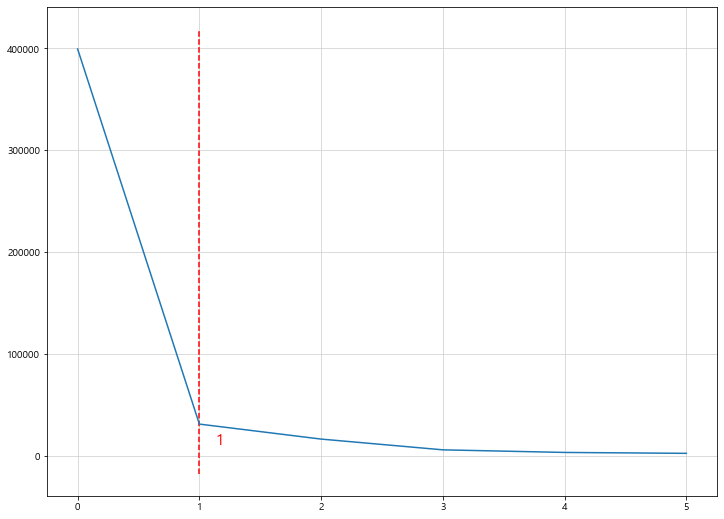

In [56]:
viz_val_counts('fuel')

- 변곡점은 1이다. 
- 가급적 많은 데이터를 살리기 위해 그래프의 기울기변화가 거의 없는 3을 기준으로 클리닝 진행
- other가 이미 있으므로, 함수에 들어갈 기준값은 2로 입력해서 other이 others가 되도록 진행

In [57]:
to_others('fuel', 2)

# 결과 확인
val_counts('fuel')

gas       399399
diesel     31077
others     24500
Name: fuel, dtype: int64

#### 7) title_status

clean         439626
rebuilt         8698
salvage         4233
others          2577
lien            2091
missing          794
parts only       194
Name: title_status, dtype: int64


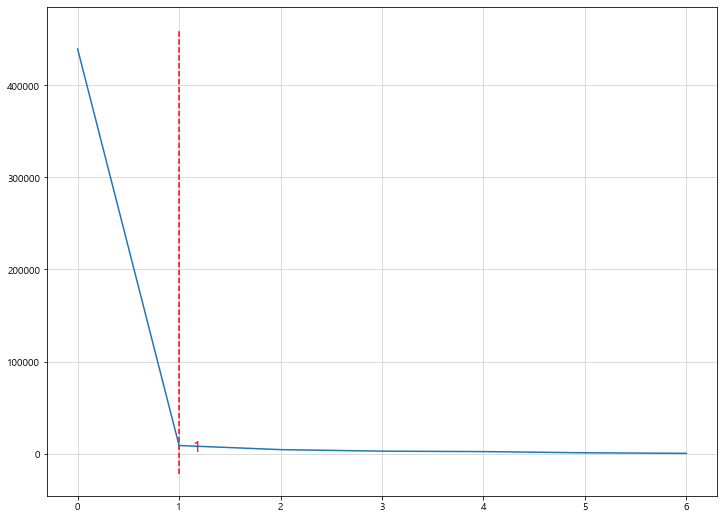

In [58]:
viz_val_counts('title_status')

- clean 이 대부분
- 도메인 지식 검색 결과 cat title은 차량 소유에 필요한 '서류' 
- 특별히 필요한 데이터가 아닌 듯 하여 drop 하기로 결정

In [59]:
df.drop('title_status', axis=1, inplace=True)

#### 8) transmission

automatic    396322
other         32186
manual        27263
others         2442
Name: transmission, dtype: int64


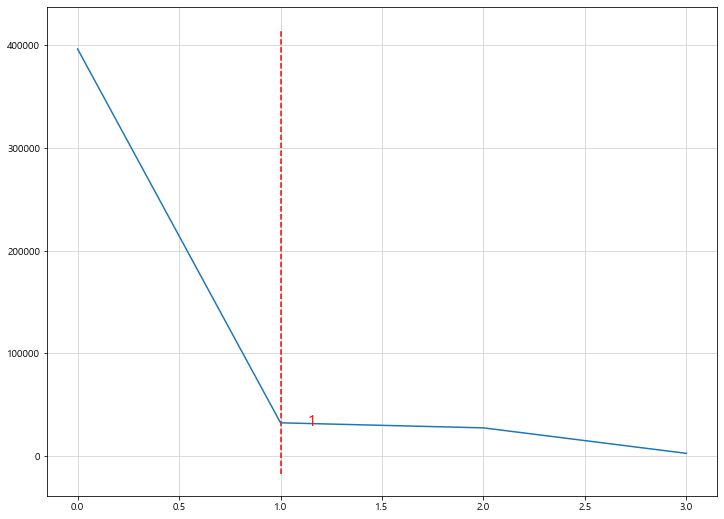

In [60]:
viz_val_counts('transmission')

- 변곡점은 1이지만, 기존 데이터가 3개 카테고리로 잘 분류되어 있어 추가 처리가 필요 없다.

#### 9) drive

4wd       139693
others    134188
fwd       122602
rwd        61730
Name: drive, dtype: int64


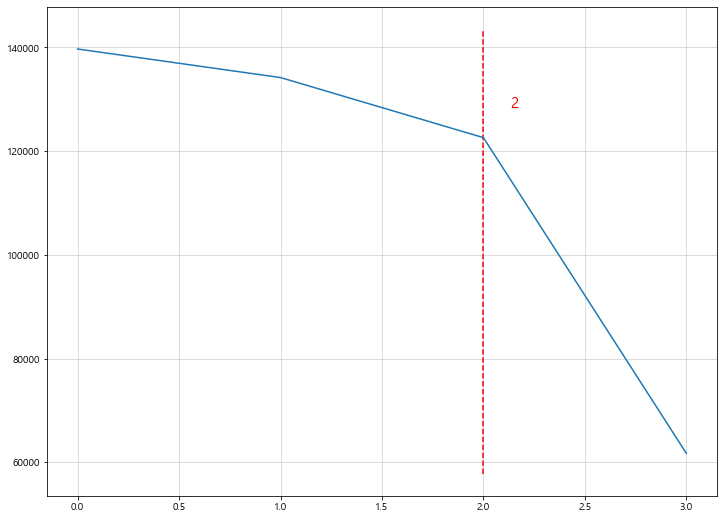

In [61]:
viz_val_counts('drive','concave')

- 변곡점은 2 이지만, 값이 차이가 나는 3의 경우도 약 6만개의 데이터가 있으므로 그대로 사용

#### 10) size

others         321348
full-size       69736
mid-size        41782
compact         21825
sub-compact      3522
Name: size, dtype: int64


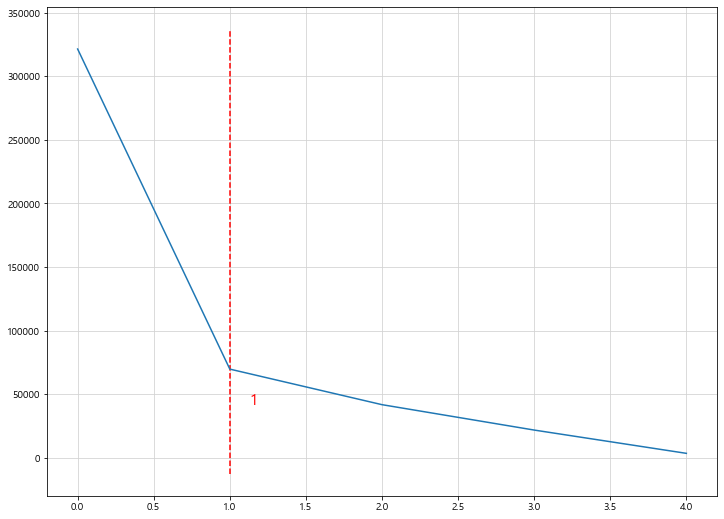

In [62]:
viz_val_counts('size')

- 변곡점은 1
- 2부터 기울기가 줄어드는 것을 감안하여 최종 2개의 카테고리 값을 갖도록 조정

In [63]:
to_others('size', 2)

# 결과 확인
val_counts('size')

full-size    69736
others       67129
Name: size, dtype: int64

#### 11) type

others         112738
sedan           92364
SUV             79882
pickup          43343
truck           35694
other           24160
coupe           19106
hatchback       16388
wagon           10473
van              9574
convertible      6864
mini-van         6263
bus               717
offroad           647
Name: type, dtype: int64


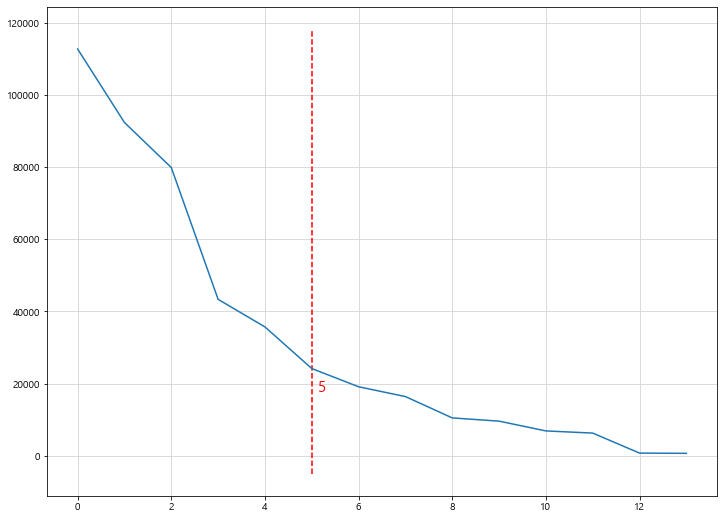

In [64]:
viz_val_counts('type')

- 변곡점은 5
- 상대적으로 기울기가 완만해지는 8을 기준으로 클리닝

In [66]:
# other과 others가 같이 있어서 컬럼명 변경하고 클리닝 진행
df.loc[df['type'] == 'other'] = 'others'

# 8개 범주로 클리닝
to_others('type', 8)


# 결과 확인
val_counts('type')

sedan        92364
SUV          79882
others       48225
pickup       43343
truck        35694
coupe        19106
hatchback    16388
wagon        10473
Name: type, dtype: int64

#### 12) paint_color

others    160894
white      76394
black      59161
silver     44034
blue       30916
red        30916
grey       30116
custom      8308
green       7352
brown       5702
yellow      1870
orange      1821
purple       729
Name: paint_color, dtype: int64


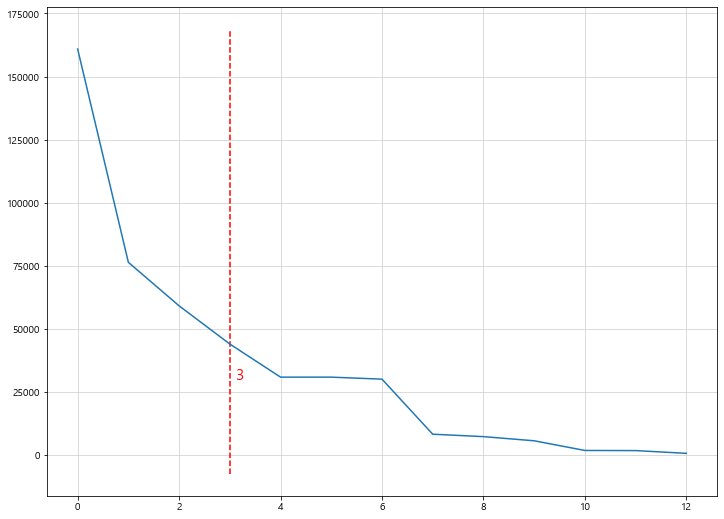

In [68]:
viz_val_counts('paint_color')

- 변곡점은 3
- 기울기가 완만해지는 7을 기준으로 클리닝 진행

In [69]:
to_others('paint_color', 7)

# 결과 확인
val_counts('paint_color')

white     76394
black     59161
others    49942
silver    44034
blue      30916
red       30916
grey      30116
Name: paint_color, dtype: int64